In [1]:
#auto reload jupyter to update notebook w.r.t changes in other linked files:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
#from xgboost.testing import root_mean_square

from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


from train_and_evaluate import load_train_test_data
from preprocessing import preprocess_data

Null values after aggregation to median
time                0
lat                 0
lon                 0
clf                 0
lwp                 0
blh                 0
cape                0
mlspf               0
mslhf               0
msshf               0
q700                0
q850                0
rh700               0
rh850               0
sst                 0
t700                0
t850                0
tcwv                0
u10                 0
u700                0
u850                0
v10                 0
v700                0
v850                0
w700                0
w850                0
Terra_descending    0
lsm                 0
eis                 0
lnNd                0
dtype: int64
Null Values:
time                0
lat                 0
lon                 0
clf                 0
lwp                 0
blh                 0
cape                0
mlspf               0
mslhf               0
msshf               0
q700                0
q850                0
rh700     

In [17]:
#Define the predictand
predictands = 'lwp'

df_train, df_test, X_train, y_train, X_test, y_test, predictors, predictands = preprocess_data(scalertype='standard',
                    outlier_method='iqr',
                    scale_predictands=True,
                    selected_predictands=None)
#df_train, df_test, X_train, y_train, X_test, y_test, predictors, predictands = load_train_test_data(predictands=predictands)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Convert pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f'train_loader: {train_loader} \n test_loader: {test_loader}' )
print(f'size of train_loader: {len(train_loader)} \n size of test_loader: {len(test_loader)}')

TypeError: can only concatenate str (not "list") to str

Neural Network Architecture

In [6]:
class MultiTargetRegressor(nn.Module):
    """Neural network for multi-target regression"""
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            # Input layer to first hidden layer
            nn.Linear(input_size, 32),
            nn.ReLU(),

            # First hidden layer to second hidden layer
            nn.Linear(32, 16),
            nn.ReLU(),

            # First hidden layer to second hidden layer
            nn.Linear(16, 10),
            nn.ReLU(),

            # Second hidden layer to output layer
            nn.Linear(10, output_size)
        )

        # Initialize weights using Kaiming He initialization for ReLU
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        """Defines forward pass through network"""
        return self.layers(x)

In [7]:
def print_model_structure(model, input_size, output_size):
    neuron_counts = [input_size]  # Start with input size
    linear_layers = []

    # Collect neuron counts for each nn.Linear layer
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            neuron_counts.append(layer.out_features)
            linear_layers.append(layer)

    # Print neurons per layer
    print("Model Structure:")
    print(f"Input layer: {neuron_counts[0]} neurons")
    for i, n in enumerate(neuron_counts[1:-1], 1):
        print(f"Hidden layer {i}: {n} neurons")
    print(f"Output layer: {neuron_counts[-1]} neurons")

    # Print total neurons (excluding input layer if you want only trainable neurons)
    total_neurons = sum(neuron_counts)
    print(f"\nTotal number of neurons (including input and output): {total_neurons}")

    # Print number of layers
    print(f"Number of layers (Linear): {len(linear_layers)}")
    print(f"Number of hidden layers: {len(linear_layers) - 1}")

# Example usage:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MultiTargetRegressor(input_size, output_size)
print_model_structure(model, input_size, output_size)


Model Structure:
Input layer: 25 neurons
Hidden layer 1: 32 neurons
Hidden layer 2: 16 neurons
Hidden layer 3: 10 neurons
Output layer: 2 neurons

Total number of neurons (including input and output): 85
Number of layers (Linear): 4
Number of hidden layers: 3


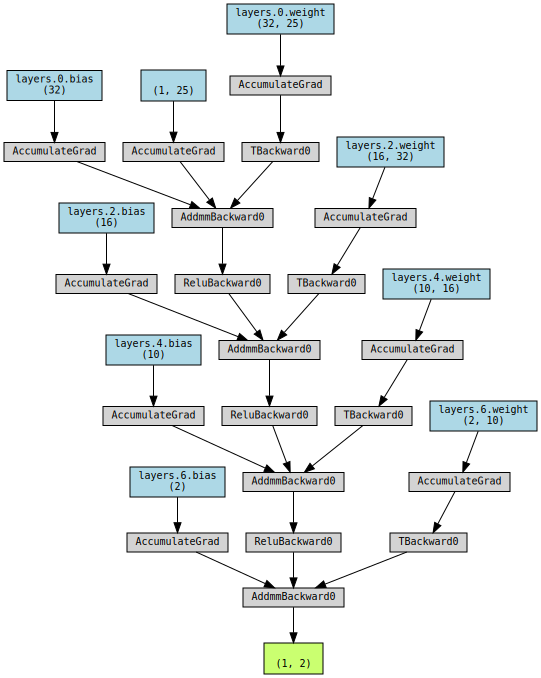

In [8]:
# Install torchviz if not already installed
# !pip install torchviz

from torchviz import make_dot
import torch

def visualize_model(model, input_size):
    # Create a dummy input tensor with the correct shape
    x = torch.randn(1, input_size, requires_grad=True)
    y = model(x)
    # Create a visualization of the computation graph
    dot = make_dot(y, params=dict(model.named_parameters()))
    return dot


input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MultiTargetRegressor(input_size, output_size)

# Example usage:
dot = visualize_model(model, input_size)
#dot.render("model_architecture", format="png")  # Saves to file
dot  # Display in Jupyter notebook


In [13]:
# If not installed, uncomment the next line:
# !pip install torchsummary

from torchsummary import summary

def visualize_model_summary(model, input_size):
    # input_size should be a tuple without batch size, e.g. (number_of_features,)
    summary(model, input_size)


# Example usage:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MultiTargetRegressor(input_size, output_size)

visualize_model_summary(model, input_size=(X_train.shape[1],))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             832
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 16]             528
              ReLU-4                   [-1, 16]               0
            Linear-5                    [-1, 2]              34
Total params: 1,394
Trainable params: 1,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


Model Training Function:

In [12]:
def train_model(model, train_loader, test_loader, num_epochs=100):
    """Training loop with validation monitoring"""
    # Loss function and optimizer
    learning_rate = 0.01
    loss_function = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

    # Track losses for visualization
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(X_batch)  # Forward pass
            loss = loss_function(outputs, y_batch)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            epoch_train_loss += loss.item()

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = loss_function(outputs, y_batch)
                epoch_val_loss += loss.item()

        # Calculate average losses
        train_loss = epoch_train_loss / len(train_loader)
        val_loss = epoch_val_loss / len(test_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


In [10]:
#Model Training

input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MultiTargetRegressor(input_size, output_size)

# Train model
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=30
)

#

/home/sparashar/Installed/miniconda3/envs/calisma/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 0.6234 | Val Loss: 0.5815
Epoch 2/30 | Train Loss: 0.5919 | Val Loss: 0.5786
Epoch 3/30 | Train Loss: 0.5866 | Val Loss: 0.5748
Epoch 4/30 | Train Loss: 0.5803 | Val Loss: 0.5766
Epoch 5/30 | Train Loss: 0.5775 | Val Loss: 0.5800
Epoch 6/30 | Train Loss: 0.5748 | Val Loss: 0.5697
Epoch 7/30 | Train Loss: 0.5747 | Val Loss: 0.5673
Epoch 8/30 | Train Loss: 0.5722 | Val Loss: 0.5679
Epoch 9/30 | Train Loss: 0.5704 | Val Loss: 0.5731
Epoch 10/30 | Train Loss: 0.5698 | Val Loss: 0.5738
Epoch 11/30 | Train Loss: 0.5696 | Val Loss: 0.5602
Epoch 12/30 | Train Loss: 0.5695 | Val Loss: 0.5611
Epoch 13/30 | Train Loss: 0.5691 | Val Loss: 0.5695
Epoch 14/30 | Train Loss: 0.5682 | Val Loss: 0.5718
Epoch 15/30 | Train Loss: 0.5683 | Val Loss: 0.5754
Epoch 16/30 | Train Loss: 0.5675 | Val Loss: 0.5797
Epoch 17/30 | Train Loss: 0.5668 | Val Loss: 0.5721
Epoch 18/30 | Train Loss: 0.5448 | Val Loss: 0.5514
Epoch 19/30 | Train Loss: 0.5415 | Val Loss: 0.5520
Epoch 20/30 | Train L

In [13]:
import torch
import torch.optim as optim

# Define your hyperparameter grid
param_grid = {
    'lr': [0.01, 0.001],
    'batch_size': [32, 64],
    'hidden1': [128, 256]
}

from itertools import product

best_val_loss = float('inf')
best_params = None

for lr, batch_size, hidden1 in product(param_grid['lr'], param_grid['batch_size'], param_grid['hidden1']):
    # Prepare data loaders with batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Define model with current hidden layer size
    model = MultiTargetRegressor(input_size, output_size)
    # Optionally, modify your model to accept hidden1 as a parameter

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Train for a few epochs (e.g., 5 for speed)
    for epoch in range(5):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = {'lr': lr, 'batch_size': batch_size, 'hidden1': hidden1}

print("Best params:", best_params)
print("Best validation loss:", best_val_loss)


KeyboardInterrupt: 

In [32]:
import random
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np

# Define the hyperparameter space
param_space = {
    'lr': [1e-3, 5e-4, 1e-4, 5e-5],
    'batch_size': [16, 32, 64, 128],
    'num_epochs': [10, 20, 30],
    # Add more hyperparameters as needed
}

n_trials = 10  # Number of random samples

best_val_loss = float('inf')
best_params = None

for trial in range(n_trials):
    # Randomly sample hyperparameters
    lr = random.choice(param_space['lr'])
    batch_size = random.choice(param_space['batch_size'])
    num_epochs = random.choice(param_space['num_epochs'])

    # Create new dataloaders for this batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    model = MultiTargetRegressor(input_size, output_size)

    # Set optimizer with sampled learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train model (use your train_model function)
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        num_epochs=num_epochs
    )

    # Use the last validation loss as the metric
    final_val_loss = val_losses[-1]

    print(f"Trial {trial+1}: lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}, val_loss={final_val_loss:.4f}")

    # Track the best hyperparameters
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_params = {
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs
        }

print("Best hyperparameters:", best_params)
print("Best validation loss:", best_val_loss)


/home/sparashar/Installed/miniconda3/envs/calisma/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 0.3935 | Val Loss: 0.3502
Epoch 2/30 | Train Loss: 0.3534 | Val Loss: 0.3271
Epoch 3/30 | Train Loss: 0.3437 | Val Loss: 0.3257
Epoch 4/30 | Train Loss: 0.3372 | Val Loss: 0.3281
Epoch 5/30 | Train Loss: 0.3329 | Val Loss: 0.3223
Epoch 6/30 | Train Loss: 0.3290 | Val Loss: 0.3257
Epoch 7/30 | Train Loss: 0.3258 | Val Loss: 0.3290
Epoch 8/30 | Train Loss: 0.3232 | Val Loss: 0.3324
Epoch 9/30 | Train Loss: 0.3211 | Val Loss: 0.3279
Epoch 10/30 | Train Loss: 0.3188 | Val Loss: 0.3263
Epoch 11/30 | Train Loss: 0.3168 | Val Loss: 0.3356
Epoch 12/30 | Train Loss: 0.3044 | Val Loss: 0.3258
Epoch 13/30 | Train Loss: 0.3014 | Val Loss: 0.3263
Epoch 14/30 | Train Loss: 0.3003 | Val Loss: 0.3260
Epoch 15/30 | Train Loss: 0.2995 | Val Loss: 0.3262
Epoch 16/30 | Train Loss: 0.2989 | Val Loss: 0.3284
Epoch 17/30 | Train Loss: 0.2984 | Val Loss: 0.3280
Epoch 18/30 | Train Loss: 0.2964 | Val Loss: 0.3278
Epoch 19/30 | Train Loss: 0.2962 | Val Loss: 0.3276
Epoch 20/30 | Train L

Best Hyperparameters when predictand = both:
Best hyperparameters: {'lr': 5e-05, 'batch_size': 64, 'num_epochs': 10}
Best validation loss: 0.3247509590034411



Model Evaluation:

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, X_test_tensor, y_test):
    """Generate predictions and calculate metrics"""
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)

    # Convert to numpy for sklearn metrics
    y_pred = y_pred_tensor.numpy()

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Method #2 from search results
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Display metrics
    print("\nFinal Model Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")  # Added from search result [1][2]
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return y_pred

Visualisation

In [15]:
 def plot_loss_curves(train_losses, val_losses):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Loss Curves when predictands = {predictands}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Execution

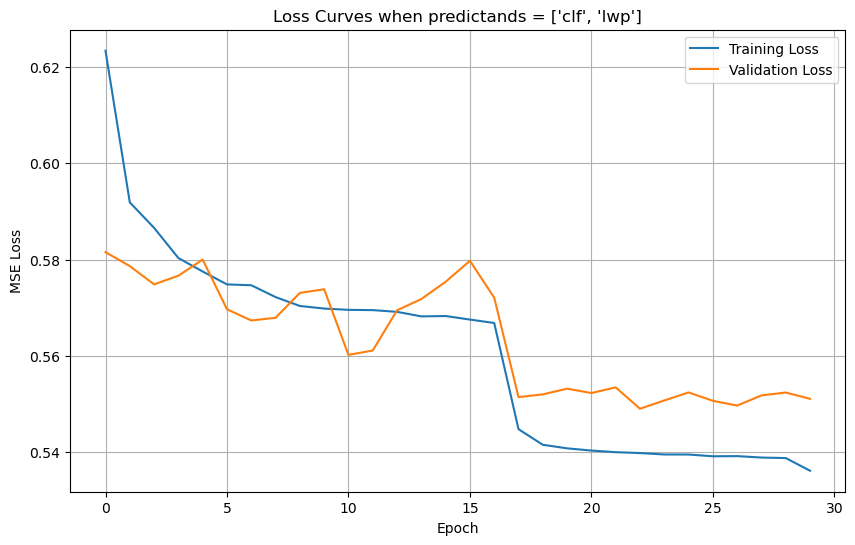


Final Model Evaluation:
MSE: 0.5683
RMSE: 0.7539
MAE: 0.5828
R²: 0.4004


array([[ 0.5297774 ,  0.33578378],
       [ 0.4705608 , -0.430565  ],
       [ 0.31108096,  0.05839671],
       ...,
       [ 0.2815234 ,  0.83397734],
       [-0.01789251,  0.2801785 ],
       [-0.71108925, -0.572792  ]], dtype=float32)

In [16]:
 #Visualize training progress
plot_loss_curves(train_losses=train_losses, val_losses=val_losses)

# Final evaluation
evaluate_model(model=model, X_test_tensor=X_test_tensor, y_test=y_test)
#y_pred = evaluate_model(model, X_test_tensor, y_test)